In [457]:
import idx2numpy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
from sklearn.metrics import confusion_matrix, accuracy_score

%matplotlib inline
import matplotlib.pyplot as plt

In [458]:
# classic + sgd + mse x4 = 0.98
# classic + sgd + cross_ent x1 = 0.9811
# classic + adam + cross_ent x3 = 0.9721
# classic + adam + cross_ent x1 = 0.9565
# classic + dropout + sgd + cross_ent x1 = 0.96
# classic + sgd + cross_ent x1 = 0.9752
# modernized + sgd + cross_ent x1 = 0.9783

# fashion
# classic + sgd + cross_ent x1 = 0.8374


In [459]:
dataset_name='mnist'
# dataset_name='fashion'
model_parameters_path = f'./{dataset_name}_net.pth'


In [460]:
training_data_path = f'./data/{dataset_name}/train-images.idx3-ubyte'
training_labels_path = f'./data/{dataset_name}/train-labels.idx1-ubyte'

training_data = idx2numpy.convert_from_file(training_data_path)
training_labels = idx2numpy.convert_from_file(training_labels_path)

# normalize data
training_data = training_data / 255

training_data = torch.from_numpy(training_data).view(-1, 1, 1, 28, 28).float()


In [461]:
def print_img(img):
    plt.imshow(img, cmap=plt.cm.binary)
    plt.show()


training image at index 1543


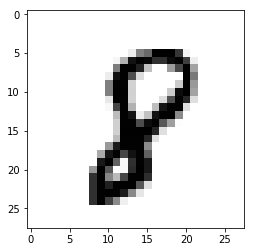

In [462]:
train_image_index = 1543
print('training image at index', train_image_index)
print_img(training_data[train_image_index][0][0])


In [463]:
def array_mul(ar):
    result = 1
    for x in ar:
        result *= x
    return result


In [464]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))

        # reshape for full connection layer
        x = x.view(-1, array_mul(x.size()[1:]))

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [465]:
net = Net()
print(net)


Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [466]:
criterion = nn.CrossEntropyLoss()
num_of_epoch = 1
optimizer = optim.SGD(net.parameters(), lr=0.01)
# optimizer = optim.Adam(net.parameters(), lr=0.01)


In [467]:
batch_size_for_info = 5000

def start_train():
    for epoch in range(num_of_epoch):
        # shuffle data
        permutation = torch.randperm(training_data.shape[0])
        local_training_data = training_data[permutation]
        local_training_labels = training_labels[permutation]

        running_loss = 0

        for i in range(local_training_data.shape[0]):
            optimizer.zero_grad()

            net_predict_train = net(local_training_data[i])

            target = torch.tensor([local_training_labels[i]]).long()

            loss = criterion(net_predict_train, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % batch_size_for_info == batch_size_for_info - 1:
                print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / batch_size_for_info}')
                running_loss = 0.0

    print('Training finished')


In [468]:
test_data_path = f'./data/{dataset_name}/t10k-images.idx3-ubyte'
test_labels_path = f'./data/{dataset_name}/t10k-labels.idx1-ubyte'

test_data = idx2numpy.convert_from_file(test_data_path)
test_labels = idx2numpy.convert_from_file(test_labels_path)

# normalize data
test_data = test_data / 255


In [469]:
# start_train()
# torch.save(net.state_dict(), model_parameters_path)


[1, 5000] loss: 0.8359452614307403
[1, 10000] loss: 0.23073533141613006
[1, 15000] loss: 0.183032044506073
[1, 20000] loss: 0.14303853681087494
[1, 25000] loss: 0.1161121464252472
[1, 30000] loss: 0.12439854154586792
[1, 35000] loss: 0.1034897052526474
[1, 40000] loss: 0.10790359997749328
[1, 45000] loss: 0.09429240219593048
[1, 50000] loss: 0.09835604238510132
[1, 55000] loss: 0.08414424772262573
[1, 60000] loss: 0.08853060286045074
Training finished


In [470]:
testing_net = Net()
testing_net.load_state_dict(torch.load(model_parameters_path))


In [471]:
Y_result = []
n = 10
similar_matrix = np.full((n, n), -1)
similar_matrix_value = np.full((n, n), -math.inf)

net.eval()
for i in range(len(test_data)):
    tens_train = torch.from_numpy(test_data[i]).view(1, 1, 28, 28).float()
    net_predict_train = testing_net(tens_train)
    res_percentage, result = torch.max(net_predict_train.data, 1)

    res_percentage = res_percentage[0].item()
    result = result[0].item()

    if similar_matrix_value[test_labels[i]][result] < res_percentage:
        similar_matrix_value[test_labels[i]][result] = res_percentage
        similar_matrix[test_labels[i]][result] = i

    Y_result.append(result)

    if i % 1000 == 999:
        print((i + 1) // 1000)

print('testing done')


1
2
3
4
5
6
7
8
9
10
testing done


In [472]:
conf_matrix = confusion_matrix(test_labels, np.array(Y_result))
accuracy = accuracy_score(test_labels, np.array(Y_result))

print('accuracy', accuracy)
print(conf_matrix)


accuracy 0.9789
[[ 960    0    3    0    0    0    7    2    6    2]
 [   0 1131    0    3    0    0    1    0    0    0]
 [   0    4 1006    0    2    0    4   14    2    0]
 [   0    0    3  994    0    0    0    7    5    1]
 [   0    1    2    0  967    0    6    0    0    6]
 [   0    0    0   25    0  860    3    1    0    3]
 [   4    4    1    0    1    5  943    0    0    0]
 [   0    5    5    1    4    0    0  998    3   12]
 [   6    0    8    1    0    2    1    1  953    2]
 [   0    1    0    2   13    8    1    4    3  977]]


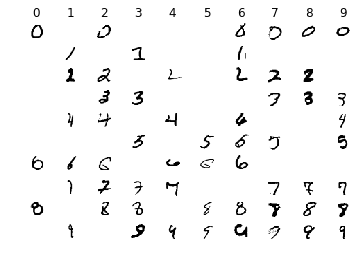

In [473]:
f, axarr = plt.subplots(10,10)

for i in range(10):
    for j in range(10):
        if similar_matrix[i][j] != -1:
            axarr[i,j].imshow(test_data[similar_matrix[i][j]], cmap=plt.cm.binary)
        else:
            axarr[i,j].imshow(np.zeros((28, 28)), cmap=plt.cm.binary)
        axarr[i,j].axis('off')

    axarr[0,i].set_title(str(i))# set title

plt.show()
